Named-entity recognition (NER) (also known as (named) entity identification, entity chunking, and entity extraction) is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

In [1]:
import nltk
import random
import numpy as np
from IPython import display
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
import sklearn

C:\Users\s381731\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(123456789)

# Data Loading

ConLL-2002 dataset samples: The left column is the list of words of a sentence, the right column is the list of tag of each word. Thus, the sentence in the following picture is: <br /> 

*'Wolff, currently a journalist in Argentina, played with Del Bosque in the final years of the seventies in Real Madrid.'* <br />

The tag list is: <br />
B-PER, O, O, ..., B-LOC, O, ..., B-PER, I-PER, O, ..., B-ORG, I-ORG, O <br />

where, person names (PER), organizations (ORG), locations (LOC) and miscellaneous names (MISC)

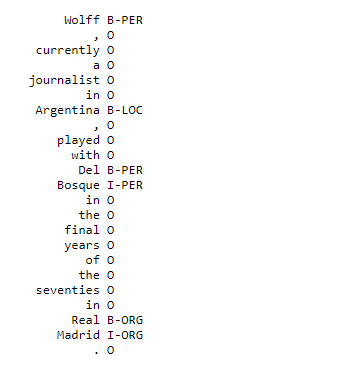

In [3]:
display.Image('imgs/ConLL-2002_dataset_samples.PNG')

In [4]:
# Use the NLTK conll2002 dataset as the corpus
conll2002_corpus = nltk.corpus.conll2002.iob_sents()
print(conll2002_corpus[0])      # Take the first sample in the corpus

# Zip to get words and tags in the sample list
# which is the first and the third item in each tuple
words, _, tags = list(zip(*conll2002_corpus[0])) 
print(words)
print(tags)
assert len(words) == len(tags), "Different size"

[('Sao', 'NC', 'B-LOC'), ('Paulo', 'VMI', 'I-LOC'), ('(', 'Fpa', 'O'), ('Brasil', 'NC', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
('Sao', 'Paulo', '(', 'Brasil', ')', ',', '23', 'may', '(', 'EFECOM', ')', '.')
('B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O')


In [5]:
# Get words and tags from the whole dataset
data = []
word_list = []
tag_list = []

for l in conll2002_corpus:
    words, _, tags = list(zip(*l))
    word_list.append(words)
    tag_list.append(tags)
    data.append([words, tags])

In [6]:
print(data[0])

[('Sao', 'Paulo', '(', 'Brasil', ')', ',', '23', 'may', '(', 'EFECOM', ')', '.'), ('B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O')]


# Data preprocessing

Create vocabulary set and tag set

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Collect all words and tags in the dataset to be the vocab and tagset
vocab = list(set(flatten(word_list)))
tagset = list(set(flatten(tag_list)))

In [8]:
print(vocab[:10])
print(tagset)

['MUERTE', 'ultraviolet', 'extrema', 'suggestieve', 'territoriumafbakening', 'vleermuisgeluiden', '5.51', 'dromer', 'perste', 'politieman']
['B-LOC', 'I-PER', 'I-ORG', 'B-ORG', 'I-MISC', 'O', 'B-PER', 'I-LOC', 'B-MISC']


Indexing the vocabulary list and the tag list

In [9]:
# Build the word2index and index2word dictionary of the vocab list
word2index = {'<U>':0, '</>':1}
init_len = len(word2index)
word2index.update({w:(i + init_len) for i, w in enumerate(vocab)})
index2word = {i:w for w, i in word2index.items()}

In [10]:
print(word2index['</>'], index2word[1])

1 </>


In [11]:
# Build the word2index and index2word dictionary of the tags list
tag2index = {t:i for i, t in enumerate(tagset)}
index2tag = {i:t for t, i in tag2index.items()}
print(tag2index)
print(index2tag)

{'B-LOC': 0, 'I-PER': 1, 'I-ORG': 2, 'B-ORG': 3, 'I-MISC': 4, 'O': 5, 'B-PER': 6, 'I-LOC': 7, 'B-MISC': 8}
{0: 'B-LOC', 1: 'I-PER', 2: 'I-ORG', 3: 'B-ORG', 4: 'I-MISC', 5: 'O', 6: 'B-PER', 7: 'I-LOC', 8: 'B-MISC'}


Create n-grams window for samples construction

In [12]:
# Construct the ngrams for building training samples
# Center the word in the n_gram slicing windows as the target 
# For each slicing window, Mark it with the tag of the center word (target).
# In this way, the tag can be recognized considering context around the targeted word
# Use the first sample in the data to demonstrate the idea
WINDOW_SIZE = 2
sample = data[0] # sample[0] => sentence words, sample[1] => word tags 

# </>, </>, 'w1', 'w2', ..., 'wn-1', 'wn', </>, </>
sent = ['</>'] * WINDOW_SIZE + list(sample[0]) + ['</>'] * WINDOW_SIZE
print(sent, '\n')

n_grams_window = flatten([list(nltk.ngrams(sent, WINDOW_SIZE * 2 + 1))])
for i in n_grams_window: print(i)

print()
print(sample[1])

training_samples = [[n_grams_window[i], sample[1][i]] for i in range(len(sample[0]))]

['</>', '</>', 'Sao', 'Paulo', '(', 'Brasil', ')', ',', '23', 'may', '(', 'EFECOM', ')', '.', '</>', '</>'] 

('</>', '</>', 'Sao', 'Paulo', '(')
('</>', 'Sao', 'Paulo', '(', 'Brasil')
('Sao', 'Paulo', '(', 'Brasil', ')')
('Paulo', '(', 'Brasil', ')', ',')
('(', 'Brasil', ')', ',', '23')
('Brasil', ')', ',', '23', 'may')
(')', ',', '23', 'may', '(')
(',', '23', 'may', '(', 'EFECOM')
('23', 'may', '(', 'EFECOM', ')')
('may', '(', 'EFECOM', ')', '.')
('(', 'EFECOM', ')', '.', '</>')
('EFECOM', ')', '.', '</>', '</>')

('B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O')


In [13]:
samples = []
for i in tqdm(range(len(data))):
    sample = data[i] # sample[0] => sentence words, sample[1] => word tags 
    sent = ['</>'] * WINDOW_SIZE + list(sample[0]) + ['</>'] * WINDOW_SIZE
    n_grams_window = flatten([list(nltk.ngrams(sent, WINDOW_SIZE * 2 + 1))])
    samples.extend([[n_grams_window[i], sample[1][i]] for i in range(len(sample[0]))])

100%|██████████| 35651/35651 [00:01<00:00, 26875.38it/s]


In [14]:
print(len(samples))
samples[:10]

678377


[[('</>', '</>', 'Sao', 'Paulo', '('), 'B-LOC'],
 [('</>', 'Sao', 'Paulo', '(', 'Brasil'), 'I-LOC'],
 [('Sao', 'Paulo', '(', 'Brasil', ')'), 'O'],
 [('Paulo', '(', 'Brasil', ')', ','), 'B-LOC'],
 [('(', 'Brasil', ')', ',', '23'), 'O'],
 [('Brasil', ')', ',', '23', 'may'), 'O'],
 [(')', ',', '23', 'may', '('), 'O'],
 [(',', '23', 'may', '(', 'EFECOM'), 'O'],
 [('23', 'may', '(', 'EFECOM', ')'), 'O'],
 [('may', '(', 'EFECOM', ')', '.'), 'B-ORG']]

Split the dataset

In [15]:
def spilt_data(dataset, training_ratio=0.9):
    random.shuffle(dataset)
    split_index = int(len(dataset) * training_ratio)
    return dataset[:split_index], dataset[split_index:]

In [16]:
train_data, test_data = spilt_data(samples)
print(len(train_data))
print(train_data[:10])
print(len(test_data))
print(test_data[:10])

610539
[[('proyecto', 'por', 'parte', 'de', 'los'), 'O'], [('del', 'ELN', 'y', 'las', 'FARC'), 'O'], [('7', ',', '6', ',', '5'), 'O'], [('la', 'sensatez', ',', 'el', 'sentido'), 'O'], [('</>', '</>', 'Col', "d'Izoard", '2.360'), 'B-LOC'], [('hebben', 'ons', 'namelijk', 'voorgenomen', 'om'), 'O'], [('km/h', 'E.', 'Bernoldi', '(', 'BRA'), 'I-PER'], [('un', 'privilegiado', 'por', 'haber', 'conseguido'), 'O'], [('"', 'De', 'twee', 'kanten', 'zijn'), 'O'], [('intervenir', 'fueron', 'los', 'agentes', 'de'), 'O']]
67838
[[('próximos', 'dos', 'años', '.', '</>'), 'O'], [('que', 'ha', 'tratado', 'otras', 'cuestiones'), 'O'], [('rond', 'de', 'tafel', 'te', 'gaan'), 'O'], [('del', 'futuro', 'Defensor', 'del', 'Pueblo'), 'B-PER'], [('Moran', ',', 'al', 'pronosticar', 'la'), 'O'], [('de', 'Estado', 'contradice', 'la', 'versión'), 'O'], [('ze', 'te', 'vinden', '.', '</>'), 'O'], [('met', 'vakken', 'als', 'handel', 'allicht'), 'O'], [('</>', '</>', '"', 'Neen.', 'we'), 'O'], [('</>', '</>', 'KDM', ')

# Build the model

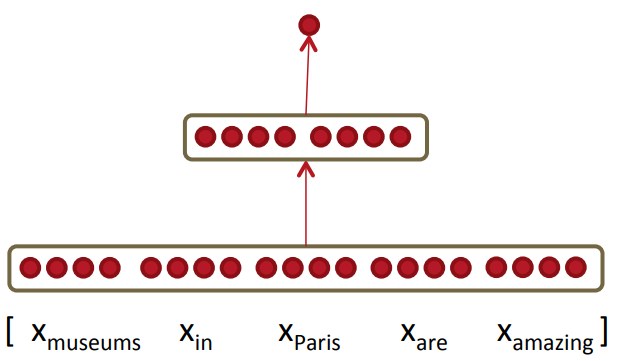

In [17]:
display.Image('imgs/window-classifier-architecture.png')

In [18]:
class WindowClassifier(nn.Module): 
    def __init__(self, vocab_size, embedding_size, window_size, hidden_size, output_size):

        super(WindowClassifier, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.h_layer1 = nn.Linear(embedding_size * (window_size * 2 + 1), hidden_size)
        self.h_layer2 = nn.Linear(hidden_size, hidden_size)
        self.o_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, inputs, is_training=False): 
        embeds = self.embed(inputs) # BxWxD
        concated = embeds.view(-1, embeds.size(1) * embeds.size(2)) # Bx(W*D)
        h0 = self.relu(self.h_layer1(concated))
        if is_training:
            h0 = self.dropout(h0)
        h1 = self.relu(self.h_layer2(h0))
        if is_training:
            h1 = self.dropout(h1)
        out = self.softmax(self.o_layer(h1))
        return out

# Train the model

In [19]:
# Hyper parameters
BATCH_SIZE = 128
EMBEDDING_SIZE = 50 # x (WINDOW_SIZE*2+1) = 250
HIDDEN_SIZE = 300
EPOCH = 3
LEARNING_RATE = 0.001

In [20]:
# Check and set running device (gpu or cpu)
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [21]:
# Define and initalize the model 
model = WindowClassifier(len(word2index), EMBEDDING_SIZE, WINDOW_SIZE, HIDDEN_SIZE, len(tag2index))
if USE_CUDA:
    model = model.cuda()

In [22]:
# A simple demo on how to embed the tensor 
embeds = nn.Embedding(len(word2index), 50, device='cuda')
words, tags = zip(*train_data[0:128])
words_tensor = torch.tensor([[word2index[w] if word2index.get(w) is not None 
                                else word2index['<U>'] for w in s] for s in words], device='cuda')
# print(words_tensor)
print(embeds(words_tensor).size())

# 128 * 5 * 50 => 128 * 250
# 128 * 250 X 250 * 300 => 128 * 300
# 128 * 300 X 300 * 300 => 128 * 300
# 128 * 300 X 300 * 9 => 128 * 9
out = model(words_tensor)
print(out.size())

tags_tensor = torch.tensor([tag2index[t] for t in tags])
print(tags_tensor)

torch.Size([128, 5, 50])
torch.Size([128, 9])
tensor([5, 5, 5, 5, 0, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 7, 4, 6, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 4, 5, 2, 5, 5, 5, 5,
        5, 5, 5, 0, 5, 3, 5, 5, 5, 5, 5, 5, 5, 1, 8, 5, 5, 5, 7, 5, 5, 5, 5, 5,
        5, 5, 5, 6, 6, 5, 3, 1, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5,
        5, 4, 5, 5, 5, 8, 4, 5, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5,
        5, 1, 5, 5, 5, 5, 5, 5])


In [23]:
# Get batch from the training dataset for model traing
def get_batch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [24]:
# Define the loss function using the cross entropy loss function
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.MultiLabelMarginLoss()

In [25]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<U>'], seq))
    return Variable(LongTensor(idxs))

def prepare_tag(tag, tag2index):
    return Variable(LongTensor([tag2index[tag]]))

In [27]:
for e in range(EPOCH):
    print(f'{e+1}/{EPOCH} =======================')

    losses = [] # for loss tracking

    for i, batch in enumerate(get_batch(BATCH_SIZE, train_data)):
        words, tags = list(zip(*batch)) # Unpack batch samples as words and tags

        # Convert words and tags as tensor
        # words_tensor will be in the size of batch_size x 2 * WINDOW_SIZE + 1 x embedding_size
        # Which is 128 x (2 * 2 + 1) x 50
        inputs = torch.cat([prepare_sequence(sent, word2index).view(1, -1) for sent in words])
        targets = torch.cat([prepare_tag(t, tag2index) for t in tags])
        # print(inputs)

        # Forward
        model.zero_grad()
        preds = model(inputs, is_training=True)
        # print(preds)
        loss = loss_function(preds, targets)
        losses.append(loss.item())

        # Backward
        loss.backward()

        # Update
        optimizer.step()

        # Track the errors
        if i % 1000 == 0:
            print(f'{i}/{len(train_data) // BATCH_SIZE}: mean_loss = {np.mean(losses)}')
            losses = [] # 

1/3 =======================
0/4769: mean_loss = 2.2212369441986084
1000/4769: mean_loss = 0.4691313533037901
2000/4769: mean_loss = 0.37745162553340195
3000/4769: mean_loss = 0.3225526345670223
4000/4769: mean_loss = 0.2863086482286453
2/3 =======================
0/4769: mean_loss = 0.21026121079921722
1000/4769: mean_loss = 0.2208796297609806
2000/4769: mean_loss = 0.21064140663668512
3000/4769: mean_loss = 0.2013148185275495
4000/4769: mean_loss = 0.18835350628569722
3/3 =======================
0/4769: mean_loss = 0.1388850063085556
1000/4769: mean_loss = 0.15221127769630402
2000/4769: mean_loss = 0.1445002423049882
3000/4769: mean_loss = 0.14699054403603076
4000/4769: mean_loss = 0.14067921970225872


# Test

 Get prediction using test sample

In [28]:
# Use a sample in the test set as a demo
rand_idx = random.randint(0, len(test_data))
test_sample = test_data[rand_idx]
print(test_sample)

# Extract words and tag from the sample, then convert all words into a tensor
words, tag = test_sample[0], test_sample[1]
words_tensor = torch.tensor([word2index[w] if word2index.get(w) is not None else word2index['<U>'] for w in words], device='cuda')
print(words_tensor)

# Use the forward pass to get the prediction tensor
out = model(words_tensor.view(1, -1))
print(out)

# Get the index of the biggest item in the tensor as the final prediction
tag_idx = out.max(1)[1]
print(f'word: {words[WINDOW_SIZE]}, tag prediction: {index2tag[tag_idx.item()]}')

[('L.', 'Ronald', 'Hubbard', ',', 'el'), 'I-PER']
tensor([64240, 20084, 46052, 21186, 64464], device='cuda:0')
tensor([[-10.6950,  -0.0203,  -6.0117, -10.9404,  -4.3081,  -6.6141,  -7.2713,
          -6.1801, -12.6987]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
word: Hubbard, tag prediction: I-PER


Compute prediction accuracy on the test set

In [29]:
# Test on the whole test set using the F1 score
n_corrent = 0 # Count the number of corrent prediction
for_f1_score = []

for i in tqdm(range(len(test_data))):
    sample = test_data[i]

    words, tag = sample[0], sample[1]
    w_t = torch.tensor([word2index[w] if word2index.get(w) is not None else word2index['<U>'] for w in words], device='cuda')
    out = model(w_t.view(1, -1)).max(1)[1]
    pred = index2tag[out.item()]
    for_f1_score.append([pred, tag])

    if pred == tag:
        n_corrent += 1

100%|██████████| 67838/67838 [00:38<00:00, 1777.99it/s]


In [30]:
print(f'The accuracy : {n_corrent / len(test_data) * 100:.04f}')

The accuracy : 95.5644


Print Confusion matrix

In [31]:
y_pred, y_test = list(zip(*for_f1_score))
sorted_labels = sorted(list(set(y_test) - {'O'}), key=lambda name: (name[1:], name[0]))

y_pred = [[y] for y in y_pred]
y_test = [[y] for y in y_test]

print(sklearn.metrics.classification_report(y_pred, y_test, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.679     0.760     0.717       984
       I-LOC      0.421     0.662     0.514       204
      B-MISC      0.450     0.710     0.551       517
      I-MISC      0.451     0.599     0.515       496
       B-ORG      0.633     0.831     0.718      1079
       I-ORG      0.655     0.781     0.713       818
       B-PER      0.760     0.778     0.769      1299
       I-PER      0.856     0.832     0.844       982

   micro avg      0.648     0.770     0.704      6379
   macro avg      0.613     0.744     0.668      6379
weighted avg      0.667     0.770     0.711      6379

